In [206]:
# import packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from IPython.display import Image
import contextily as ctx
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors

In [195]:
# load data
data = pd.read_csv('data/convert_MCMF_ALL_TIME_DATA.csv', sep="\t", parse_dates=['Start Date'])
data.head()
# len(data): 84878

/var/folders/4m/9pclm3z145q989bp0z7zcgnh0000gn/T/ipykernel_865/2474162318.py:2: DtypeWarning: Columns (14,28,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/convert_MCMF_ALL_TIME_DATA.csv', sep="\t", parse_dates=['Start Date'])


,IndexRow,Id,Logo Url,Program Name,Description,Org Name,Category Name,Capacity,Min Age,Max Age,...,Contact Email,Contact Phone,Program Price,Geographic Cluster Name,Program Pays Participants,Program Has Scholarships,Program Provides Transportation,Latitude,Longitude,Program Provides Free Food
0,"4,568",78752,NaN,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,Academic Support,2000.0,7,15,...,recruitment@bbbschgo.org,NaN,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False
1,"4,569",78752,NaN,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,Work + Career,2000.0,7,15,...,recruitment@bbbschgo.org,NaN,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False
2,"4,562",78749,https://cityoflearning-uploads.s3.amazonaws.co...,Youth Mentoring and Academic Supports,Young Men's Educational Network provides mento...,Youth Mentoring and Academic Supports,Academic Support,100.0,12,18,...,wchatman@ymenchicago.com,NaN,Free,NORTH LAWNDALE,Not Paid,NO,NO,41.864799,-87.724800,True
3,"4,563",78749,https://cityoflearning-uploads.s3.amazonaws.co...,Youth Mentoring and Academic Supports,Young Men's Educational Network provides mento...,Youth Mentoring and Academic Supports,Music & Art.,100.0,12,18,...,wchatman@ymenchicago.com,NaN,Free,NORTH LAWNDALE,Not Paid,NO,NO,41.864799,-87.724800,True
4,"4,557",78746,https://cityoflearning-uploads.s3.amazonaws.co...,Refugee Youth Career Pathways,Refugee Youth Career Pathways (RYCP) provides ...,RefugeeOne,Managing Money.,15.0,16,24,...,NaN,NaN,Free,NaN,Not Paid,YES,YES,NaN,NaN,False


In [196]:
# get rid of some columns we may not need (for now)
clean_data = data[data['Min Age'] <= 25]

# len(clean_data): 84606

cols_to_drop = ['Logo Url', 'Contact Phone', 'Mon Start Time', 'Mon End Time', 'Tues Start Time', 'Tues End Time', 
                'Wed End Time', 'Wed Start Time', 'Thurs Start Time', 'Thurs End Time', 'Fri Start Time', 'Fri End Time', 
                'Sat Start Time', 'Sat End Time', 'Sun Start Time', 'Sun End Time', 'Scheduled Sun', 'Scheduled Mon', 'Scheduled Tues',
                'Scheduled Wed', 'Scheduled Thurs', 'Scheduled Fri', 'Scheduled Sat', 'Start Time', 'End Time', 'Registration Open',
                'Registration Deadline', 'Registration Url', 'Program Url', 'Online Address', 'Address', 'State', 'Contact Name', 
                'Contact Email', 'Contact Phone', 'City']

# Drop the columns from the DataFrame
clean_data = clean_data.drop(columns=cols_to_drop)

clean_data.head()

,IndexRow,Id,Program Name,Description,Org Name,Category Name,Capacity,Min Age,Max Age,Meeting Type,...,Start Date,End Date,Program Price,Geographic Cluster Name,Program Pays Participants,Program Has Scholarships,Program Provides Transportation,Latitude,Longitude,Program Provides Free Food
0,"4,568",78752,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,Academic Support,2000.0,7,15,face_to_face,...,2020-01-01,12/31/20,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False
1,"4,569",78752,BBBS Community Based Mentoring (Year Round),Community Based Mentoring is the traditional B...,Big Brothers Big Sisters,Work + Career,2000.0,7,15,face_to_face,...,2020-01-01,12/31/20,Free,NEAR WEST SIDE,Not Paid,YES,YES,41.886002,-87.642403,False
2,"4,562",78749,Youth Mentoring and Academic Supports,Young Men's Educational Network provides mento...,Youth Mentoring and Academic Supports,Academic Support,100.0,12,18,face_to_face,...,2020-01-01,12/31/20,Free,NORTH LAWNDALE,Not Paid,NO,NO,41.864799,-87.724800,True
3,"4,563",78749,Youth Mentoring and Academic Supports,Young Men's Educational Network provides mento...,Youth Mentoring and Academic Supports,Music & Art.,100.0,12,18,face_to_face,...,2020-01-01,12/31/20,Free,NORTH LAWNDALE,Not Paid,NO,NO,41.864799,-87.724800,True
4,"4,557",78746,Refugee Youth Career Pathways,Refugee Youth Career Pathways (RYCP) provides ...,RefugeeOne,Managing Money.,15.0,16,24,face_to_face,...,2020-01-01,12/31/20,Free,NaN,Not Paid,YES,YES,NaN,NaN,False


spring    22961
fall      22945
winter    19396
summer    19304
dtype: int64


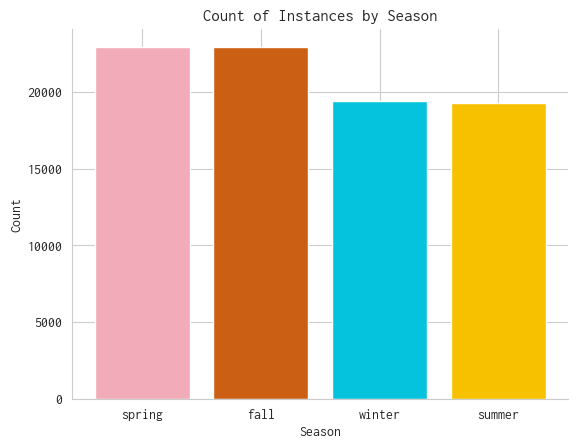

In [197]:
mpl.rcParams['font.family'] = 'Inconsolata'

months = clean_data['Start Date'].dt.month

seasons = []
for month in months:
    if month in [12, 1, 2]:
        seasons.append('winter')
    elif month in [3, 4, 5]:
        seasons.append('spring')
    elif month in [6, 7, 8]:
        seasons.append('summer')
    else:
        seasons.append('fall')

# Count the number of instances for each season
season_counts = pd.Series(seasons).value_counts()
print(season_counts)

# Create a bar plot of the season counts
colors = {'winter': '#05C3DD', 'spring': '#F1ABB9', 'summer': '#f8c100', 'fall': '#CB6015'}

fig, ax = plt.subplots()
ax.bar(season_counts.index, season_counts.values, color=[colors[season] for season in season_counts.index])

ax.set_xlabel('Season')
ax.set_ylabel('Count')
ax.set_title('Count of Instances by Season')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [198]:
num_clusters = clean_data['Geographic Cluster Name'].nunique()

print("Number of unique Geographic Clusters:", num_clusters)

Number of unique Geographic Clusters: 79


In [199]:
clean_data.loc[clean_data['Geographic Cluster Name'] == 'Bronzeville/South Lakefront', 'Geographic Cluster Name'] = 'OAKLAND'
clean_data.loc[clean_data['Geographic Cluster Name'] == 'Back of the Yards', 'Geographic Cluster Name'] = 'NEW CITY'
clean_data.loc[clean_data['Geographic Cluster Name'] == 'Little Village', 'Geographic Cluster Name'] = 'SOUTH LAWNDALE'
clean_data = clean_data.dropna(subset=['Geographic Cluster Name'])
clean_data['Geographic Cluster Name'] = clean_data['Geographic Cluster Name'].str.upper()


In [200]:
clusters = clean_data['Geographic Cluster Name'].unique()
num_programs_list = []

# Loop through each cluster and count the unique 'Program Name' values
for cluster in clusters:
    # Filter the data for the current cluster
    cluster_data = clean_data[clean_data['Geographic Cluster Name'] == cluster]
    
    # Group the data by 'Program Name'
    grouped_data = cluster_data.groupby(['Program Name'])
    
    # Count the number of unique 'Program Name' values
    num_programs = grouped_data.size().reset_index(name='count')['count'].nunique()

    # Append the number of unique 'Program Name' values to the list
    num_programs_list.append(num_programs)
    
    # Print the results
    print("Cluster:", cluster, "- Number of unique Program Names:", num_programs)

Cluster: NEAR WEST SIDE - Number of unique Program Names: 39
Cluster: NORTH LAWNDALE - Number of unique Program Names: 17
Cluster: ROSELAND - Number of unique Program Names: 17
Cluster: LINCOLN SQUARE - Number of unique Program Names: 27
Cluster: OAKLAND - Number of unique Program Names: 28
Cluster: GRAND BOULEVARD - Number of unique Program Names: 12
Cluster: KENWOOD - Number of unique Program Names: 16
Cluster: WASHINGTON PARK - Number of unique Program Names: 14
Cluster: MORGAN PARK - Number of unique Program Names: 44
Cluster: IRVING PARK - Number of unique Program Names: 60
Cluster: LOOP - Number of unique Program Names: 28
Cluster: AUSTIN - Number of unique Program Names: 21
Cluster: EAST GARFIELD PARK - Number of unique Program Names: 15
Cluster: GARFIELD PARK - Number of unique Program Names: 23
Cluster: SOUTH LAWNDALE - Number of unique Program Names: 15
Cluster: WEST GARFIELD PARK - Number of unique Program Names: 21
Cluster: SOUTH CHICAGO - Number of unique Program Names: 14

In [ ]:
num_programs_array = np.array(num_programs_list)

#Find the 10 clusters with the most programs
top_indices = np.argsort(-num_programs_array)[:10]

#Graph the 10 clusters with the most programs
sns.barplot(data = data.reset_index(), y = clusters[top_indices], x = num_programs_array[top_indices].tolist())
plt.xlim(0, 61)

plt.savefig("plots/highestclusterprogram.png", dpi=300, bbox_inches='tight')


In [ ]:
#Find the 10 clusters with the fewest programs
bottom_indices = np.argsort(num_programs_array)[:11]

#Graph the 10 clusters with the fewest programs
print(sns.barplot(data = data, y = clusters[bottom_indices], x = num_programs_array[bottom_indices]))
plt.xlim(0, 61)

plt.savefig("plots/lowestclusterprogram.png", dpi=300, bbox_inches='tight')


In [201]:
# Category Name (we want to make the categories more broad)
# get rid of Category duplicates 
clean_data=clean_data.replace({'Building & Fixing Things': 'Building and Fixing Things',
                                           'Computers.': 'Computers',
                                           'Science ': 'Science & Math',
                                           'Math': 'Science & Math',
                                           'Helping Your Community.': 'Helping Your Community',
                                           'Food.': 'Food'})
unique_categories = clean_data['Category Name'].unique()
unique_categories = pd.Series(unique_categories).drop_duplicates().tolist()
print(unique_categories)

category_counts = clean_data['Category Name'].value_counts()
category_percentages = category_counts / len(clean_data) * 100
print(category_percentages)

['Academic Support', 'Work + Career ', 'Music & Art.', 'Building and Fixing Things', 'Nature.', 'Sports + Wellness.', 'Transportation', 'Reading & Writing.', 'Performance.', 'Science & Math', 'Food', 'Teaching', 'Healthcare', 'Computers', 'Managing Money.', 'Digital Media.', 'Helping Your Community', 'Social Studies ', 'Customer/Human Service', 'Law']
Sports + Wellness.            55.977153
Music & Art.                  23.264234
Reading & Writing.             8.183458
Academic Support               2.893815
Nature.                        2.223297
Science & Math                 1.550165
Building and Fixing Things     1.432530
Computers                      1.053485
Healthcare                     0.650912
Performance.                   0.624771
Helping Your Community         0.619543
Food                           0.545041
Managing Money.                0.317614
Work + Career                  0.311079
Social Studies                 0.155539
Digital Media.                 0.132012
Custom

In [ ]:
mpl.rcParams['font.family'] = 'Inconsolata'
# Calculate the number of programs in each category
category_counts = clean_data['Category Name'].value_counts()

# Select the top 10 categories by program count
top_categories = category_counts[:10]

# Create a bar plot of the top 10 categories
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category Name')
plt.ylabel('Program Count')
plt.title('Top 10 Categories by Program Count')

plt.savefig("plots/top10categories.png", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
# Read in the Chicago community area shapefile
url = 'https://data.cityofchicago.org/api/geospatial/cauq-8yn6?method=export&format=GeoJSON'
chicago = gpd.read_file(url)

# Calculate the percentage of programs in each community area
total_programs = clean_data['Program Name'].nunique()
program_counts = (clean_data.groupby('Geographic Cluster Name')['Program Name']
                  .nunique()
                  .reset_index(name='count')
                  .assign(percentage=lambda x: (x['count'] / total_programs) * 100))
merged = chicago.merge(program_counts, left_on='community', right_on='Geographic Cluster Name')

# Create a custom colormap
cmap = ListedColormap(['#f7fcf0', '#e0f3db', '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'])

font = {'family': 'Inconsolata',
        'color':  'black',
        'weight': 'normal',
        'size': 20}

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(column='percentage', cmap=cmap, linewidth=0.8, edgecolor='gray', ax=ax)
ax.set_title('Percentage of Programs', fontdict=font)
ax.axis('off')

# Add a legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=merged['percentage'].min(), vmax=merged['percentage'].max()))
sm._A = []
cbar = fig.colorbar(sm, orientation='vertical', shrink=0.7)
cbar.ax.set_title('Percentage', fontdict=font)
cbar.ax.title.set_fontsize(14) 

# Add basemap tiles from OpenStreetMap
ctx.add_basemap(ax)

# Save the figure as a PNG image
fig.savefig('plots/map.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
# Create a choropleth map
m = folium.Map(location=[41.8781, -87.6298], zoom_start=10)
folium.Choropleth(
    geo_data=merged.to_json(),
    name='choropleth',
    data=merged,
    columns=['community', 'percentage'],
    key_on='feature.properties.community',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Percentage of Programs'
).add_to(m)

folium.LayerControl().add_to(m)

# Save the map 
m.save('plots/map.html')

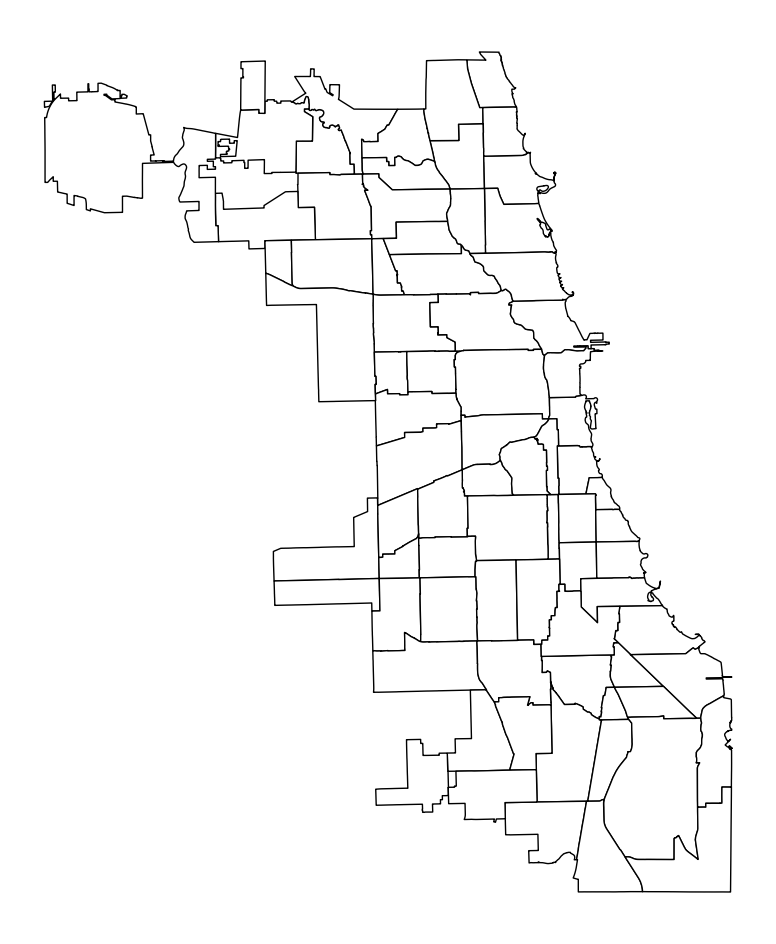

In [202]:
# Read shapefile
shape_file = gpd.read_file("chi_shapefile/geo_export_ac7aa850-c5f5-48c3-8b86-051ed02f73db.dbf")

# Plot shapefile
fig, ax = plt.subplots(figsize=(10, 12))
shape_file.plot(ax=ax, color='white', edgecolor='black')
ax.set_axis_off()
plt.show()

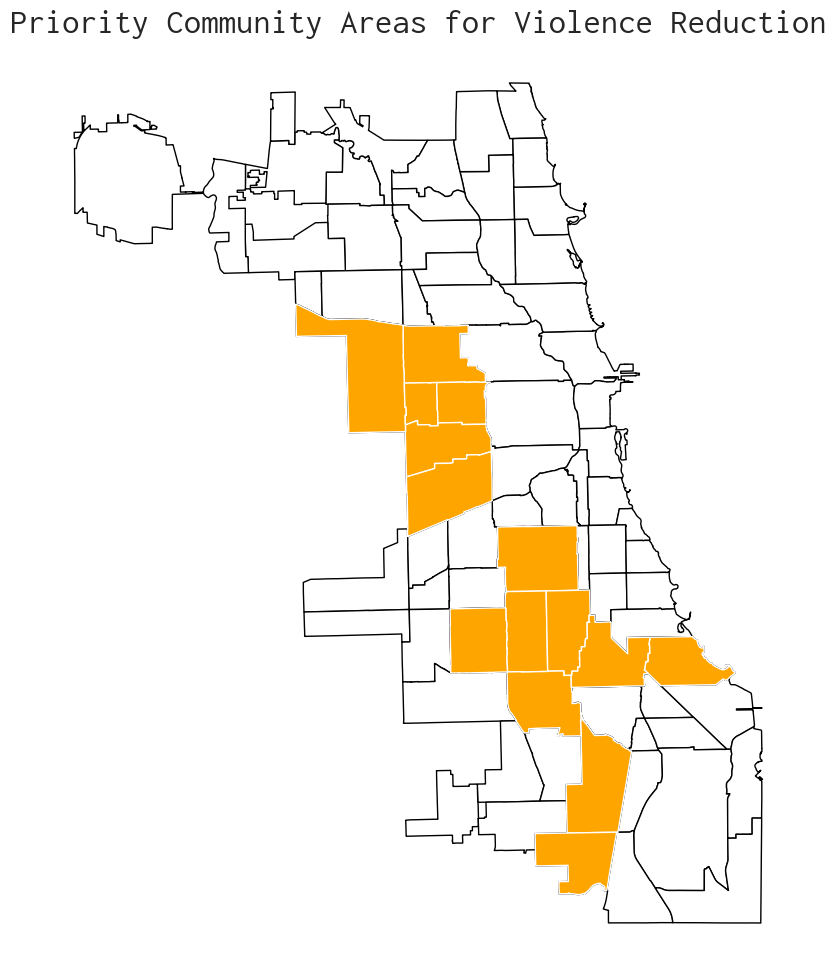

In [203]:
communities_to_highlight = [
    'AUSTIN', 'NORTH LAWNDALE', 'HUMBOLDT PARK', 'EAST GARFIELD PARK', 'ENGLEWOOD',
    'AUBURN GRESHAM', 'WEST GARFIELD PARK', 'ROSELAND', 'GREATER GRAND CROSSING',
    'WEST ENGLEWOOD', 'SOUTH SHORE', 'NEW CITY', 'CHICAGO LAWN', 'SOUTH LAWNDALE', 'WEST PULLMAN'
]
highlighted_map = chi_map[chi_map['community'].isin(communities_to_highlight)]

# Plot the original map and the highlighted communities
fig, ax = plt.subplots(figsize=(10, 12))
shape_file.plot(ax=ax, color='white', edgecolor='black')
highlighted_map.plot(ax=ax, color='Orange')
ax.set_title("Priority Community Areas for Violence Reduction", fontsize=25)

ax.set_axis_off()
plt.savefig("plots/crime_communities.png", dpi=300)

plt.show()


In [225]:
chi_map = gpd.read_file('chi_shapefile/geo_export_ac7aa850-c5f5-48c3-8b86-051ed02f73db.shx')
merged_df = pd.merge(left=chi_map, right=clean_data, left_on='community', right_on='Geographic Cluster Name')
grouped_df = merged_df.groupby('community')['Program Name'].nunique()
percentages = (grouped_df / grouped_df.sum()) * 100
chi_map['Percentage Distribution'] = chi_map['community'].map(percentages)


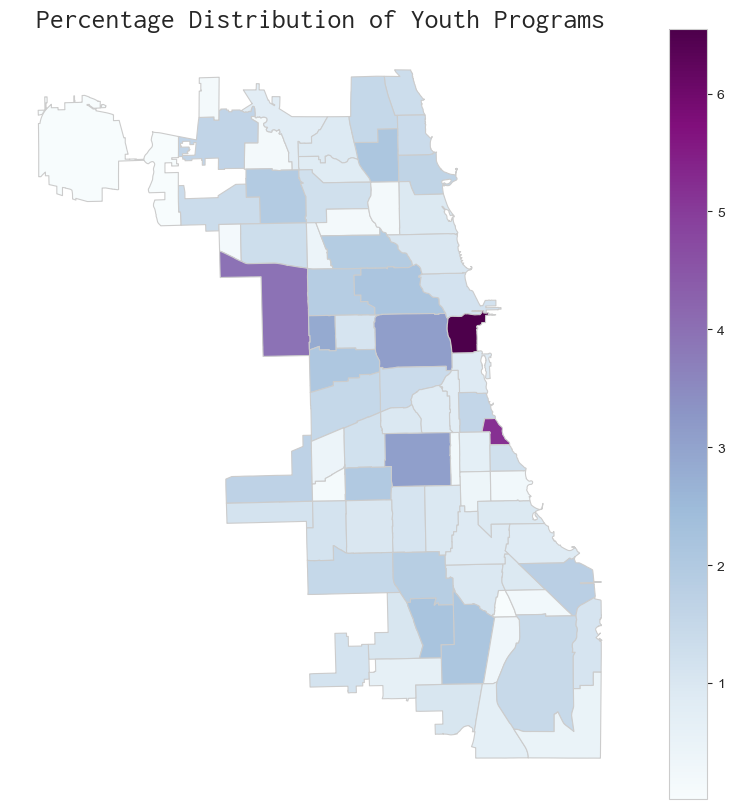

<Figure size 640x480 with 0 Axes>

In [254]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,10))
chi_map.plot(column='Percentage Distribution', cmap='BuPu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_axis_off()
ax.set_title('Percentage Distribution of Youth Programs', fontdict={'fontsize': '20', 'fontweight' : '3', 'fontname':'Inconsolata'})
plt.savefig("plots/shapefile_map.png", dpi=300)
plt.show()


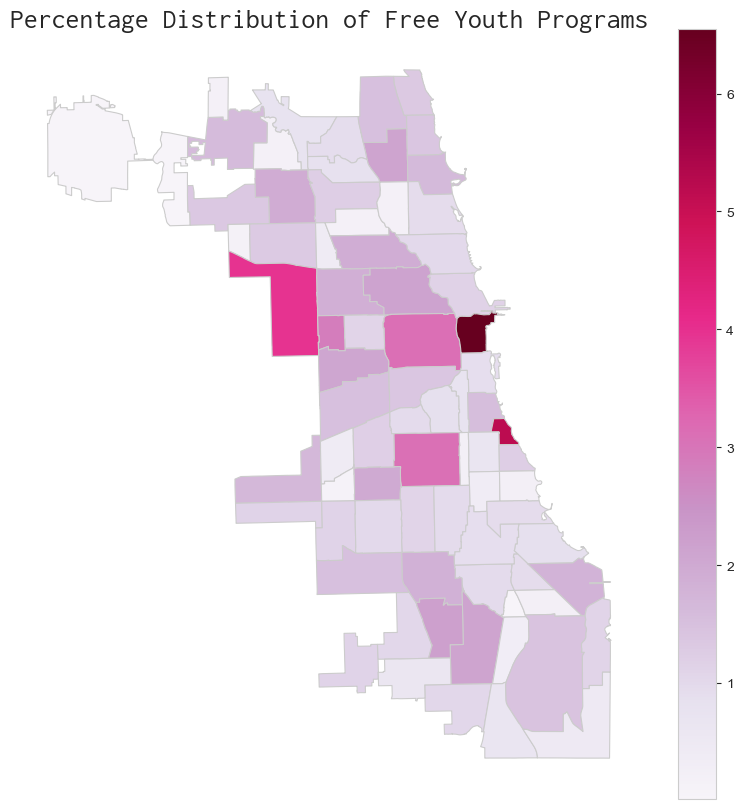

<Figure size 640x480 with 0 Axes>

In [253]:
chi_map = gpd.read_file('chi_shapefile/geo_export_ac7aa850-c5f5-48c3-8b86-051ed02f73db.shx')

accessible_data = clean_data[(clean_data['Program Price'] == 'Free')]
accessible_merged = pd.merge(left=chi_map, right=accessible_data, left_on='community', right_on='Geographic Cluster Name')
accessible = accessible_merged.groupby('community')['Program Name'].nunique()

percentages = (accessible / accessible.sum()) * 100
chi_map['Percentage Distribution'] = chi_map['community'].map(percentages)

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,10))
chi_map.plot(column='Percentage Distribution', cmap='PuRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_axis_off()
ax.set_title('Percentage Distribution of Free Youth Programs', fontdict={'fontsize': '20', 'fontweight' : '3', 'fontname':'Inconsolata'})
plt.savefig("plots/free_programs_map.png", dpi=300)
plt.show()


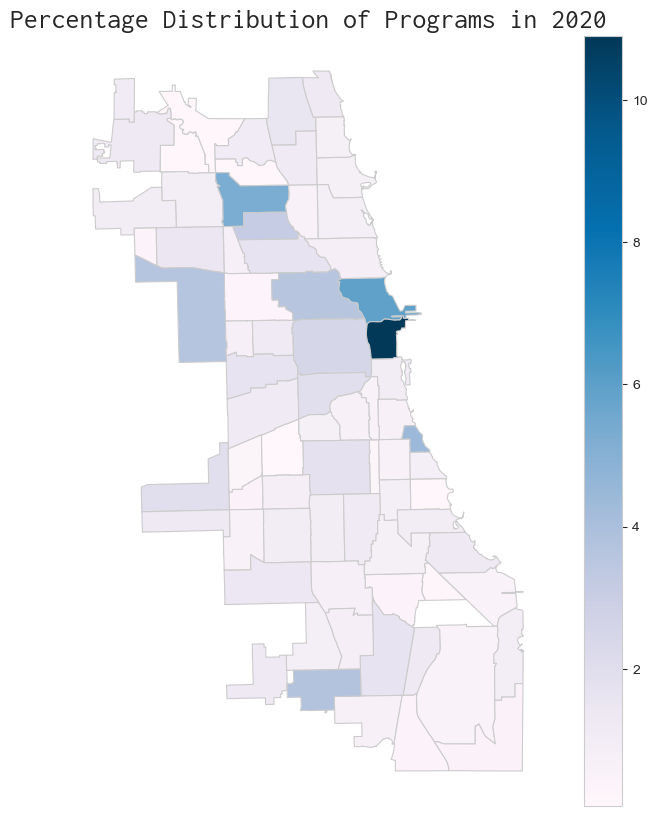

In [251]:
chi_map = gpd.read_file('chi_shapefile/geo_export_ac7aa850-c5f5-48c3-8b86-051ed02f73db.shx')

# filter clean_data for only 2020 start dates
clean_data_2020 = clean_data[clean_data['Start Date'].dt.year == 2020]

merged_2020 = pd.merge(left=chi_map, right=clean_data_2020, left_on='community', right_on='Geographic Cluster Name')

grouped_2020 = merged_2020.groupby('community')['Program Name'].nunique()

percentages_2020 = (grouped_2020 / grouped_2020.sum()) * 100

chi_map['Percentage Distribution'] = chi_map['community'].map(percentages_2020)

# plot using seaborn
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,10))
chi_map.plot(column='Percentage Distribution', cmap='PuBu', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_axis_off()
ax.set_title('Percentage Distribution of Programs in 2020', fontdict={'fontsize': '20', 'fontweight' : '3', 'fontname':'Inconsolata'})
plt.savefig("plots/2020programs_map.png", dpi=300)
plt.show()


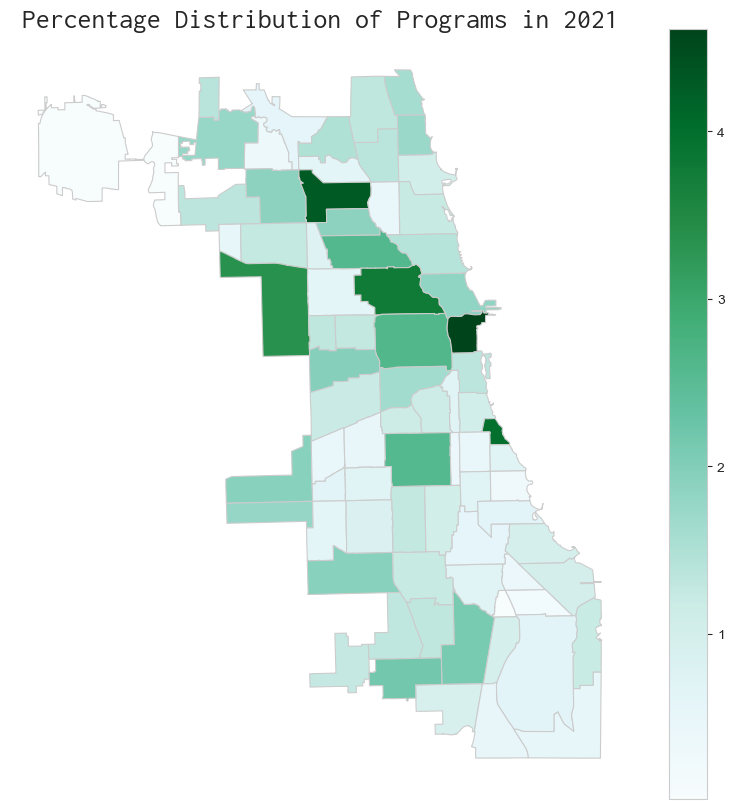

In [252]:
chi_map = gpd.read_file('chi_shapefile/geo_export_ac7aa850-c5f5-48c3-8b86-051ed02f73db.shx')

# filter clean_data for only 2021 start dates
clean_data_2021 = clean_data[clean_data['Start Date'].dt.year == 2021]

merged_2021 = pd.merge(left=chi_map, right=clean_data_2021, left_on='community', right_on='Geographic Cluster Name')

grouped_2021 = merged_2021.groupby('community')['Program Name'].nunique()

percentages_2021 = (grouped_2021 / grouped_2021.sum()) * 100

chi_map['Percentage Distribution'] = chi_map['community'].map(percentages_2021)

# plot using seaborn
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,10))
chi_map.plot(column='Percentage Distribution', cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_axis_off()
ax.set_title('Percentage Distribution of Programs in 2021', fontdict={'fontsize': '20', 'fontweight' : '3', 'fontname':'Inconsolata'})
plt.savefig("plots/2021programs_map.png", dpi=300)
plt.show()


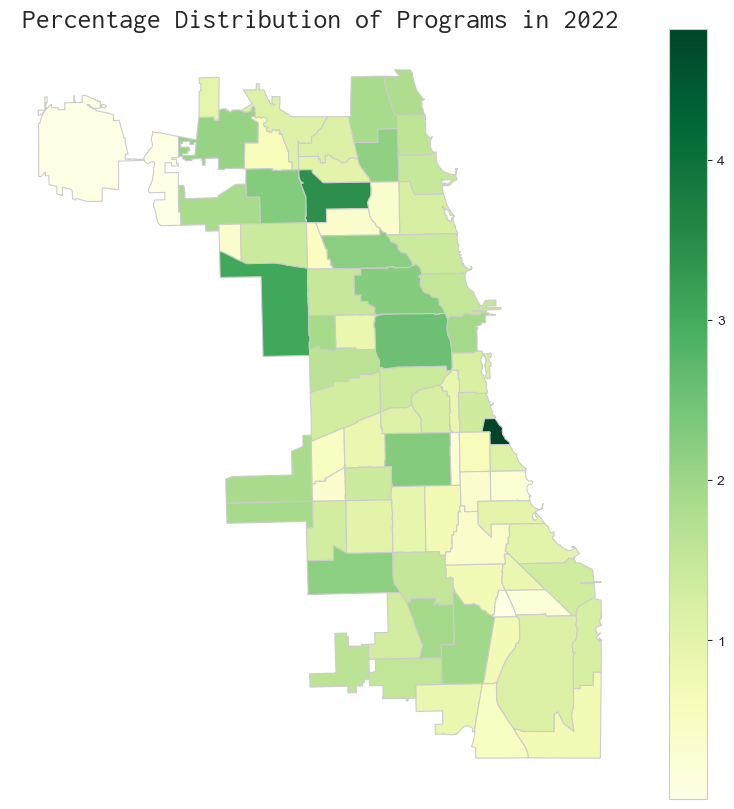

In [238]:
chi_map = gpd.read_file('chi_shapefile/geo_export_ac7aa850-c5f5-48c3-8b86-051ed02f73db.shx')

# filter clean_data for only 2022 start dates
clean_data_2022 = clean_data[clean_data['Start Date'].dt.year == 2022]

merged_2022 = pd.merge(left=chi_map, right=clean_data_2022, left_on='community', right_on='Geographic Cluster Name')

grouped_2022 = merged_2022.groupby('community')['Program Name'].nunique()

percentages_2022 = (grouped_2022 / grouped_2022.sum()) * 100

chi_map['Percentage Distribution'] = chi_map['community'].map(percentages_2022)

# plot using seaborn
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,10))
chi_map.plot(column='Percentage Distribution', cmap='YlGn', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_axis_off()
ax.set_title('Percentage Distribution of Programs in 2022', fontdict={'fontsize': '20', 'fontweight' : '3', 'fontname':'Inconsolata'})
plt.savefig("plots/2022programs_map.png", dpi=300)
plt.show()